In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm
# ??? Should we make different train periods for different models?

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

fee = 1.53e-4
padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 200
adam_lr = 1e-1
log_freq = 50

In [3]:
prev_models = []

batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading features: 0it [00:00, ?it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


 24%|██▍       | 49/200 [40:18<2:02:35, 48.71s/it]

Sharpe Ratio for the epoch: 9.1905
Average Weights:



,Weight
Cash,9.040566e-01
MPWR,2.112106e-02
FICO,1.548511e-02
BKNG,9.493832e-03
MTD,9.347924e-03
...,...
ROST,6.718533e-09
AAL,6.617763e-09
TEL,6.611150e-09
PPG,6.212772e-09


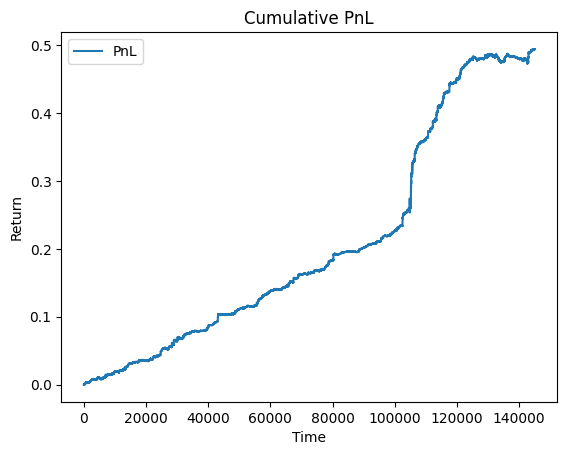

Epoch 50: Loss = -7.806875228881836
Sharpe Ratio for the epoch: 9.4550
Average Weights:



,Weight
Cash,8.584099e-01
FICO,2.852742e-02
NVR,1.930067e-02
MPWR,1.797972e-02
MTD,1.362638e-02
...,...
ROST,7.119163e-09
TEL,7.003635e-09
AAL,6.994720e-09
PPG,6.600004e-09


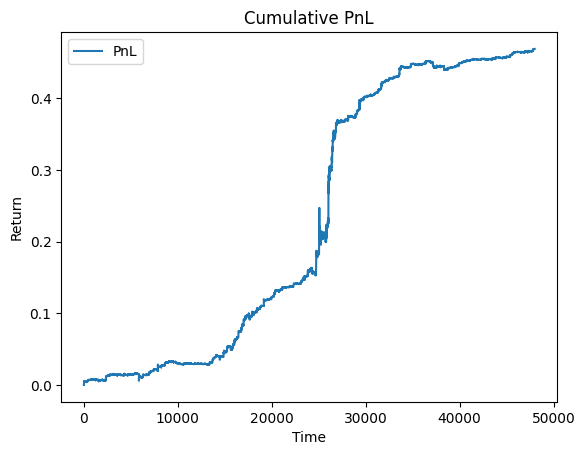

 50%|████▉     | 99/200 [1:20:47<1:21:40, 48.52s/it]

Sharpe Ratio for the epoch: 11.7798
Average Weights:



,Weight
Cash,9.100693e-01
MPWR,2.278231e-02
FICO,1.639332e-02
MTD,8.916619e-03
BKNG,8.518447e-03
...,...
MCD,1.690876e-10
ROST,1.638225e-10
TEL,1.604985e-10
PPG,1.574412e-10


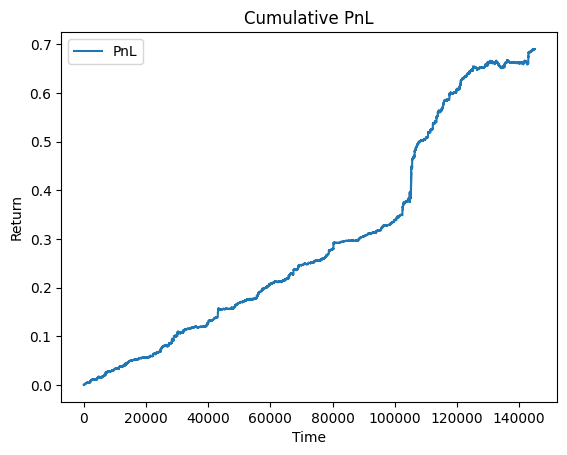

Epoch 100: Loss = -10.899377822875977
Sharpe Ratio for the epoch: 9.0894
Average Weights:



,Weight
Cash,8.677373e-01
FICO,2.542303e-02
NVR,2.119070e-02
MPWR,1.679005e-02
MTD,1.372897e-02
...,...
MCD,1.651128e-10
ROST,1.599553e-10
TEL,1.565953e-10
PPG,1.542174e-10


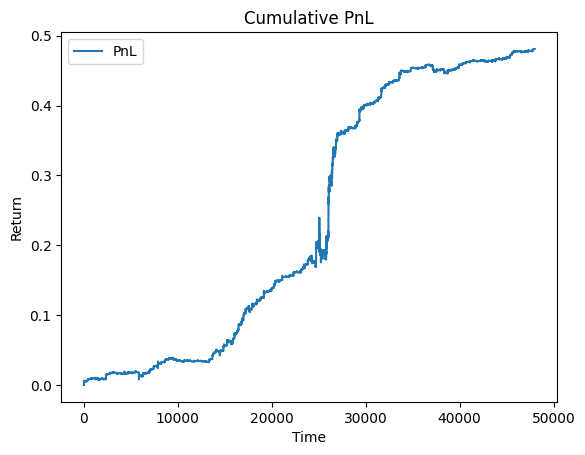

 74%|███████▍  | 149/200 [2:01:18<41:13, 48.49s/it]  

Sharpe Ratio for the epoch: 13.4162
Average Weights:



,Weight
Cash,9.107094e-01
MPWR,2.389521e-02
FICO,1.657982e-02
MTD,9.124639e-03
BKNG,7.883755e-03
...,...
PPG,4.420034e-12
TEL,4.341436e-12
ROST,4.335713e-12
MCD,4.050463e-12


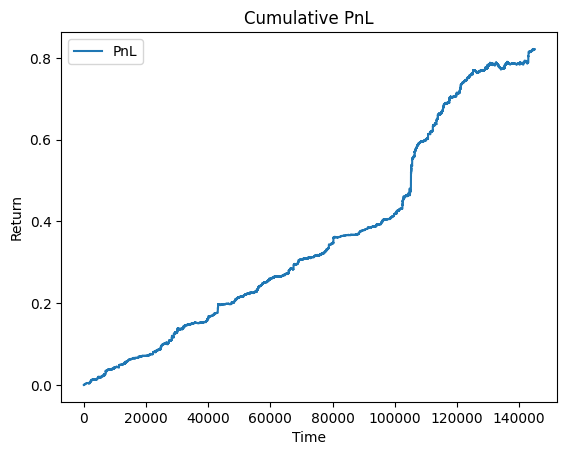

Epoch 150: Loss = -11.516819953918457
Sharpe Ratio for the epoch: 9.0970
Average Weights:



,Weight
Cash,8.738700e-01
FICO,2.395956e-02
NVR,2.072949e-02
MPWR,1.511957e-02
MTD,1.374042e-02
...,...
PPG,4.054207e-12
TEL,3.965954e-12
ROST,3.964517e-12
MCD,3.701372e-12


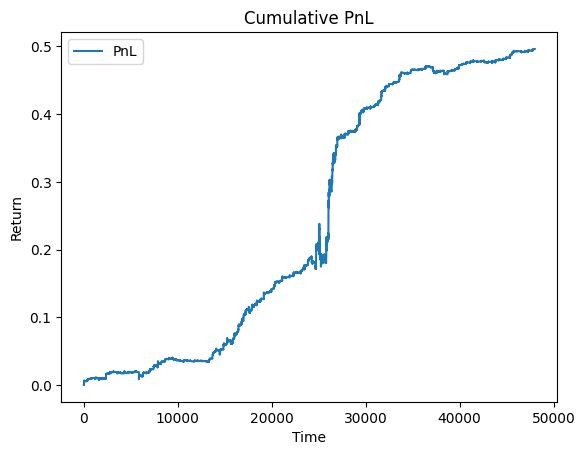

100%|█████████▉| 199/200 [2:41:54<00:48, 48.66s/it]

Sharpe Ratio for the epoch: 14.5649
Average Weights:



,Weight
Cash,9.141436e-01
MPWR,2.277948e-02
FICO,1.599294e-02
MTD,8.992247e-03
BKNG,6.450497e-03
...,...
MCD,2.539545e-13
TEL,2.476224e-13
ROST,2.387356e-13
TGT,2.275954e-13


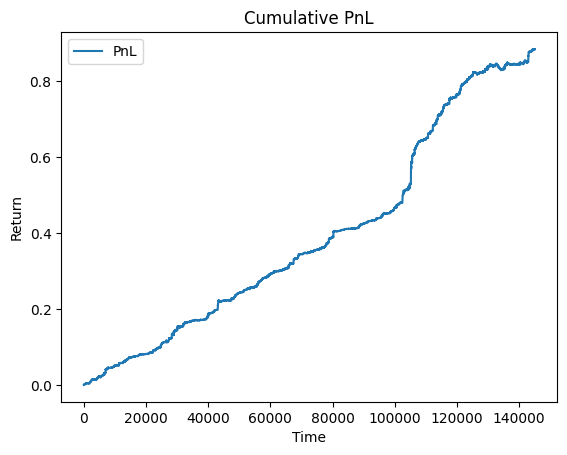

Epoch 200: Loss = -11.661640167236328
Sharpe Ratio for the epoch: 9.4746
Average Weights:



,Weight
Cash,8.763294e-01
FICO,2.549438e-02
NVR,1.920848e-02
MPWR,1.403558e-02
MTD,1.394389e-02
...,...
MCD,2.320055e-13
TEL,2.263587e-13
ROST,2.184614e-13
TGT,2.088168e-13


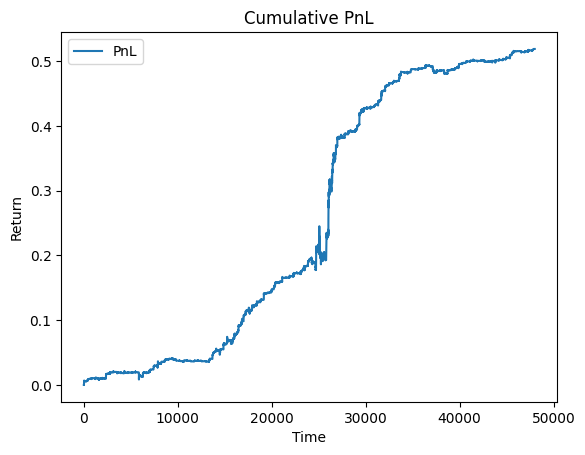

100%|██████████| 200/200 [2:42:44<00:00, 48.82s/it]


Iteration 1 completed.


  0%|          | 0/200 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  0%|          | 0/200 [00:09<?, ?it/s]


RuntimeError: output with shape [1000, 1] doesn't match the broadcast shape [1000, 1000]

In [4]:
from copy import deepcopy
for i in range(10):
    
    model = SimplePortfolioAllocator(
        cmf_dim=cmf_dim,
        num_assets=num_assets,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

    loss_fn = StreamingSharpeLoss(
        fee=fee,
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    for epoch in tqdm(range(num_epochs)):
        if epoch in batch_size_config:
            print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
            batch_size = batch_size_config[epoch]
            pipeline = FeaturesPipeline(
                path_to_data,
                padding=padding,
                batch_size=batch_size,
                split_dates=split_dates,
                split_names=split_names
            )

        loss_fn.reset()
        pipeline.reset()
        for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

            # Перевод в тензоры
            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

            if len(common_feats) != batch_size:
                continue

            cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
            for prev_model in prev_models:
                cash_left *= prev_model(common_feats, asset_feats)[:, -1]

            optimizer.zero_grad()

            # Вычисляем веса
            weights = model(common_feats, asset_feats)

            # Обновляем метрику
            loss_value = loss_fn.forward(
                weights=weights,
                returns=fut_ret,
                prev_model_cash=cash_left,
                min_prices=min_prices,
                market_caps=market_caps
            )
            loss_value.backward()

            optimizer.step()

        if (epoch + 1) % log_freq == 0:
            _, weights_df = loss_fn.plot_whole_epoch_loss()
            weights_df.to_csv(f'weights_iteration_{i}_epoch_{epoch + 1}.csv')
            torch.save(model.state_dict(), f'model_iteration_{i}_epoch_{epoch + 1}.pth')
            print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
        loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

        for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

            if len(common_feats) != batch_size:
                continue

            cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
            for prev_model in prev_models:
                cash_left *= prev_model(common_feats, asset_feats)[:, -1]

            weights = model(common_feats, asset_feats)
            loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

        if (epoch + 1) % log_freq == 0:
            loss_fn.plot_whole_epoch_loss()
        loss_fn.reset()

    prev_models.append(deepcopy(model))
    print(f"Iteration {i + 1} completed.")

  0%|          | 0/200 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


 24%|██▍       | 49/200 [41:47<2:08:30, 51.06s/it]

Sharpe Ratio for the epoch: 2.8529
Average Weights:



,Weight
Cash,8.850685e-01
BKNG,4.005624e-02
IP,1.532918e-03
JPM,4.973672e-05
IBM,1.093582e-05
...,...
SJM,1.305806e-09
VRSN,1.231977e-09
ALB,1.229242e-09
LKQ,1.222754e-09


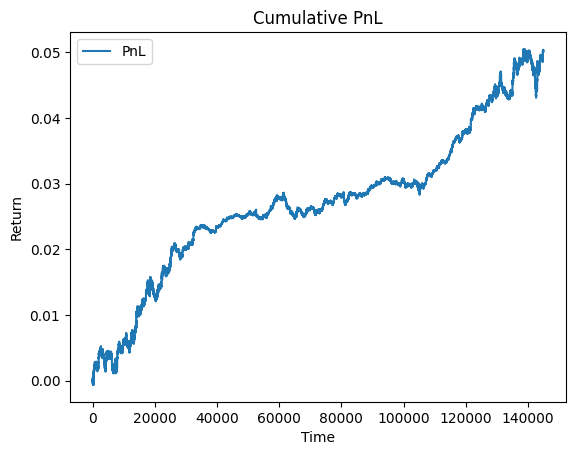

Epoch 50: Loss = -6.3187031745910645
Sharpe Ratio for the epoch: 6.8989
Average Weights:



,Weight
Cash,7.909706e-01
BKNG,8.198789e-02
IP,3.262139e-03
JPM,7.377352e-05
IBM,1.662970e-05
...,...
SJM,1.971520e-09
VRSN,1.859774e-09
ALB,1.852018e-09
LKQ,1.844065e-09


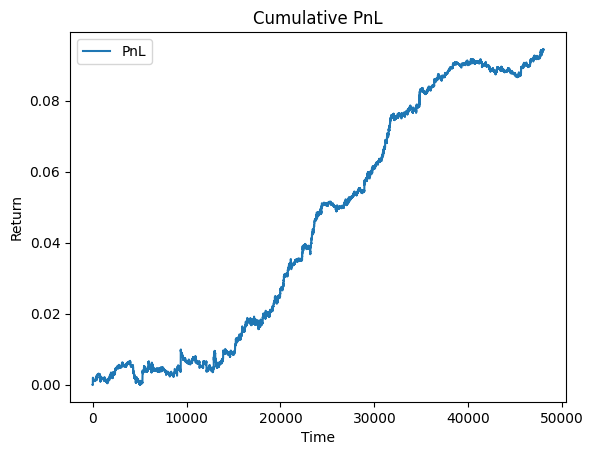

 50%|████▉     | 99/200 [1:24:31<1:27:18, 51.87s/it]

Sharpe Ratio for the epoch: 9.5926
Average Weights:



,Weight
Cash,8.840454e-01
MPWR,2.009054e-02
FICO,1.416917e-02
BKNG,8.419369e-03
IP,5.134183e-06
...,...
TEL,7.699295e-11
CAG,7.561718e-11
MO,7.539207e-11
MCD,6.373961e-11


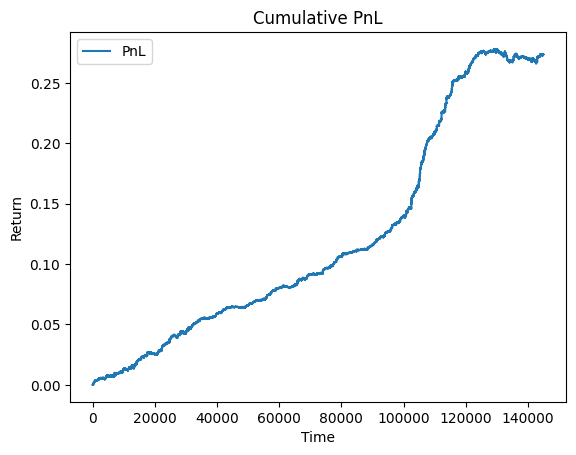

Epoch 100: Loss = -1.5323363542556763
Sharpe Ratio for the epoch: 11.7064
Average Weights:



,Weight
Cash,8.261623e-01
MPWR,2.141812e-02
FICO,1.870668e-02
BKNG,1.003663e-02
IP,5.200417e-06
...,...
TEL,7.735537e-11
CAG,7.596258e-11
MO,7.582625e-11
MCD,6.403958e-11


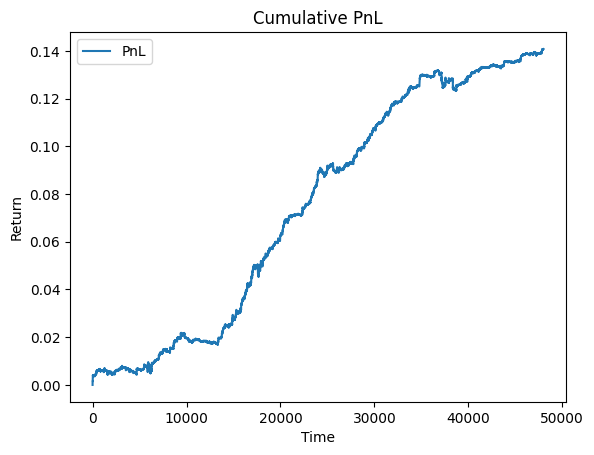

 74%|███████▍  | 149/200 [2:06:48<41:24, 48.71s/it]  

Sharpe Ratio for the epoch: 10.3544
Average Weights:



,Weight
Cash,8.845777e-01
MPWR,2.000700e-02
FICO,1.430538e-02
BKNG,7.840353e-03
IP,9.089248e-08
...,...
CAG,2.271534e-12
YUM,2.235292e-12
MO,2.117282e-12
AME,1.974364e-12


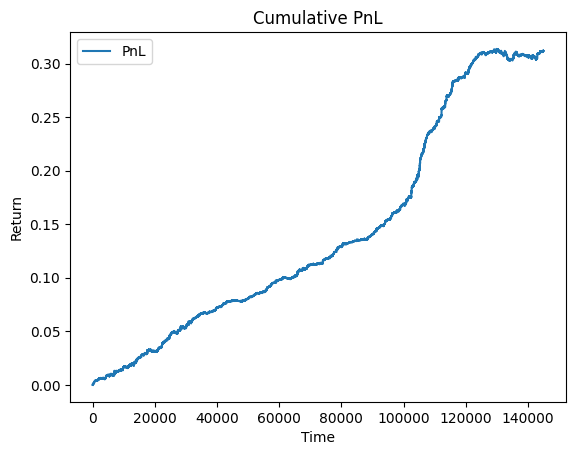

Epoch 150: Loss = -3.8575239181518555
Sharpe Ratio for the epoch: 11.8575
Average Weights:



,Weight
Cash,8.247509e-01
FICO,2.173722e-02
MPWR,1.986062e-02
BKNG,9.980769e-03
IP,9.128033e-08
...,...
CAG,2.292292e-12
YUM,2.265677e-12
MO,2.142618e-12
AME,1.987354e-12


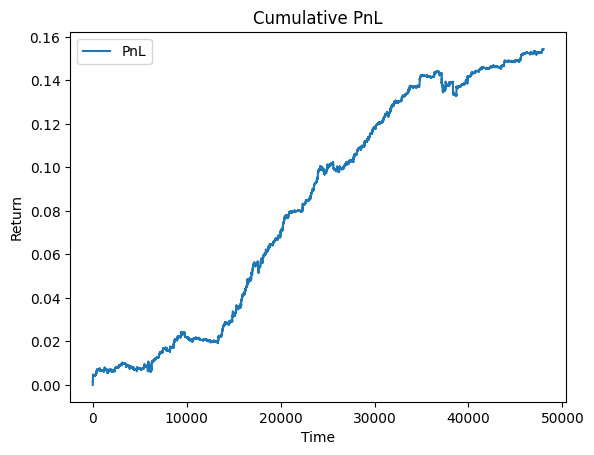

100%|█████████▉| 199/200 [2:48:53<00:52, 52.21s/it]

Sharpe Ratio for the epoch: 10.7574
Average Weights:



,Weight
Cash,8.871504e-01
MPWR,1.896657e-02
FICO,1.334614e-02
BKNG,7.267370e-03
IP,1.994888e-09
...,...
CAG,1.529118e-13
ROST,1.527654e-13
AME,1.484699e-13
MO,1.483348e-13


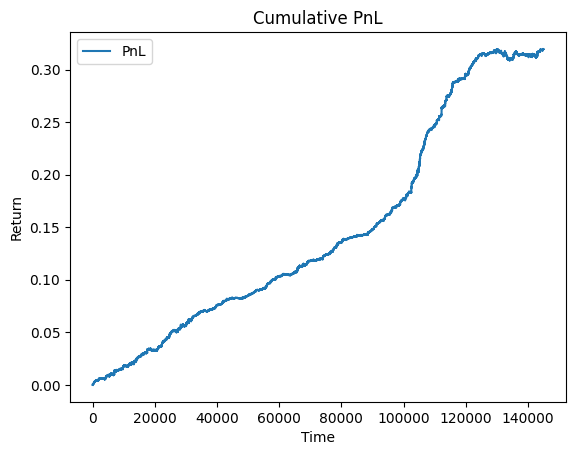

Epoch 200: Loss = -5.371626853942871
Sharpe Ratio for the epoch: 11.9479
Average Weights:



,Weight
Cash,8.277847e-01
FICO,2.106391e-02
MPWR,1.741950e-02
BKNG,1.006135e-02
IP,1.940724e-09
...,...
CAG,1.537247e-13
ROST,1.533654e-13
MO,1.494447e-13
AME,1.489935e-13


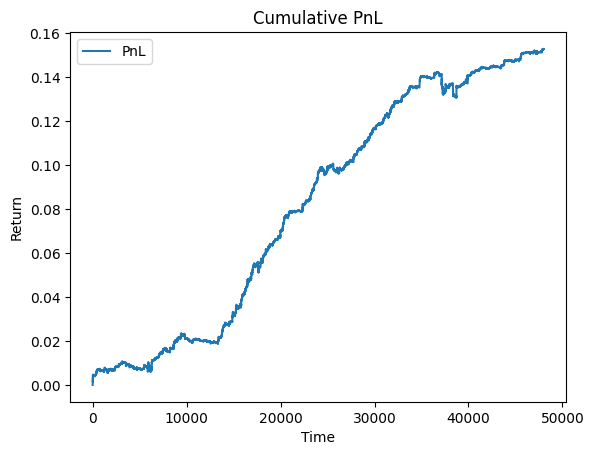

100%|██████████| 200/200 [2:49:44<00:00, 50.92s/it]

Iteration 2 completed.



  0%|          | 0/200 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


 24%|██▍       | 49/200 [43:23<2:06:00, 50.07s/it]

Sharpe Ratio for the epoch: -0.8396
Average Weights:



,Weight
Cash,7.594011e-01
JPM,1.240941e-01
IP,3.654358e-05
WFC,5.516576e-06
KEY,2.599488e-06
...,...
COO,4.679175e-09
VRSN,4.638718e-09
AME,4.605201e-09
GPC,4.532667e-09


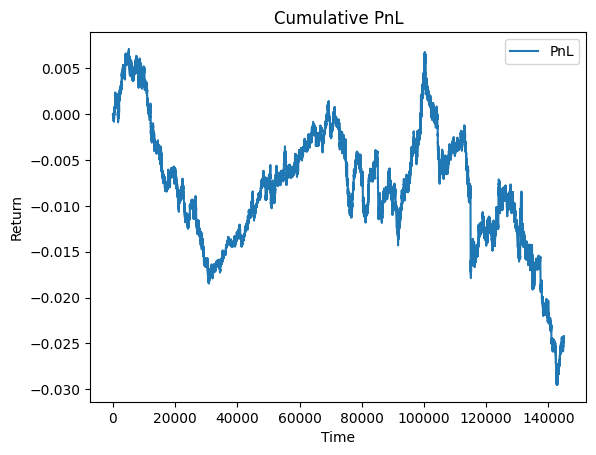

Epoch 50: Loss = -6.124835968017578
Sharpe Ratio for the epoch: -1.6107
Average Weights:



,Weight
Cash,7.222839e-01
JPM,1.054207e-01
IP,5.421100e-05
WFC,4.889185e-06
KEY,2.259735e-06
...,...
COO,4.015743e-09
VRSN,3.979174e-09
AME,3.929264e-09
GPC,3.880186e-09


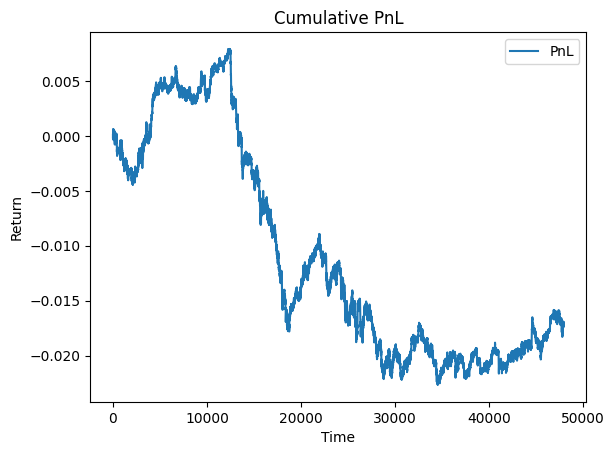

 50%|████▉     | 99/200 [1:28:05<1:26:14, 51.23s/it]

Sharpe Ratio for the epoch: -0.8041
Average Weights:



,Weight
Cash,7.616241e-01
JPM,1.219148e-01
IP,2.070727e-05
WFC,3.150021e-07
KEY,1.329966e-07
...,...
HSY,3.382553e-10
ROST,3.320833e-10
VRSN,3.301456e-10
GPC,2.914273e-10


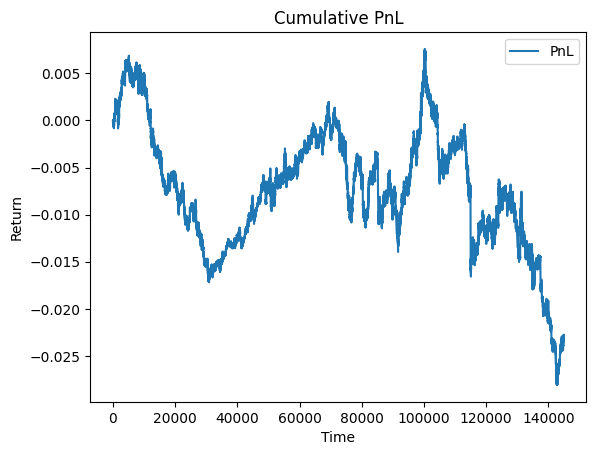

Epoch 100: Loss = -6.285835266113281
Sharpe Ratio for the epoch: -1.5971
Average Weights:



,Weight
Cash,7.238569e-01
JPM,1.038956e-01
IP,3.055183e-05
WFC,2.747070e-07
KEY,1.128958e-07
...,...
SJM,2.870545e-10
ROST,2.800991e-10
VRSN,2.795100e-10
GPC,2.460001e-10


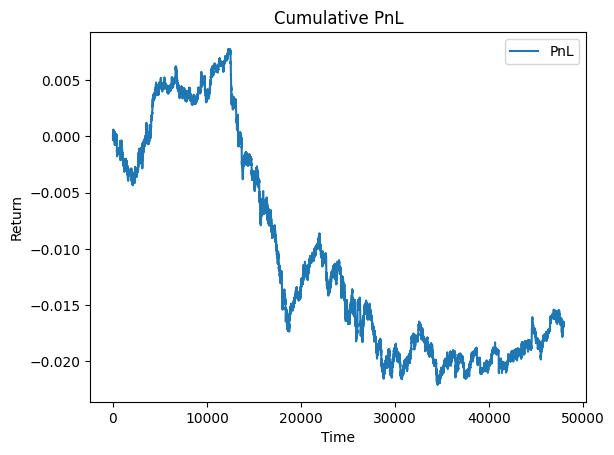

 50%|█████     | 100/200 [1:29:24<1:29:24, 53.65s/it]


KeyboardInterrupt: 

In [11]:
from copy import deepcopy

model0 = SimplePortfolioAllocator(
    cmf_dim=cmf_dim,
    num_assets=num_assets,
).to(device)
model0.load_state_dict(torch.load('model_iteration_0_epoch_200.pth'))
prev_models = [model0]

for i in range(1, 10):
    
    # ad-hoc so far, mb add this to pipeline
    train_cash_left = []
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            cash_left *= prev_model(common_feats, asset_feats)[:, -1:]
        train_cash_left.append(cash_left.detach())
    
    test_cash_left = []
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):
        
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)
        
        if len(common_feats) != batch_size:
            continue
        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            cash_left *= prev_model(common_feats, asset_feats)[:, -1:]
        test_cash_left.append(cash_left.detach())

    model = SimplePortfolioAllocator(
        cmf_dim=cmf_dim,
        num_assets=num_assets,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

    loss_fn = StreamingSharpeLoss(
        fee=fee,
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    for epoch in tqdm(range(num_epochs)):
        if epoch in batch_size_config:
            print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
            batch_size = batch_size_config[epoch]
            pipeline = FeaturesPipeline(
                path_to_data,
                padding=padding,
                batch_size=batch_size,
                split_dates=split_dates,
                split_names=split_names
            )

        loss_fn.reset()
        pipeline.reset()
        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('train'), train_cash_left):

            # Перевод в тензоры
            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

            if len(common_feats) != batch_size:
                continue

            optimizer.zero_grad()

            # Вычисляем веса
            weights = model(common_feats, asset_feats)

            # Обновляем метрику
            loss_value = loss_fn.forward(
                weights=weights,
                returns=fut_ret,
                prev_model_cash=cash_left,
                min_prices=min_prices,
                market_caps=market_caps
            )
            loss_value.backward()

            optimizer.step()

        if (epoch + 1) % log_freq == 0:
            _, weights_df = loss_fn.plot_whole_epoch_loss()
            weights_df.to_csv(f'weights_iteration_{i}_epoch_{epoch + 1}.csv')
            torch.save(model.state_dict(), f'model_iteration_{i}_epoch_{epoch + 1}.pth')
            print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
        loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('test'), test_cash_left):

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

            if len(common_feats) !=  batch_size:
                continue

            weights = model(common_feats, asset_feats)
            loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

        if (epoch + 1) % log_freq == 0:
            loss_fn.plot_whole_epoch_loss()
        loss_fn.reset()

    prev_models.append(deepcopy(model))
    print(f"Iteration {i + 1} completed.")